### Import libraries

In [1]:
import pandas as pd 
import numpy as np
import sys
import re
import requests
import scipy.stats
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
import nltk
from rake_nltk import Rake
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
data1 = pd.read_csv("jobs.csv")

In [3]:
data2 = pd.read_csv("jobs2.csv")

In [4]:
data3 = pd.read_csv("jobs3.csv")

In [5]:
display(data1.shape)
display(data2.shape)
display(data3.shape)

(4291, 8)

(3750, 8)

(864, 8)

In [6]:
data = pd.concat([data1, data2, data3], ignore_index=True, sort=False)

In [7]:
data.shape

(8905, 8)

# Cleaning

### Drop duplicates

In [8]:
duplicates = data[data.duplicated(keep='first', subset=['title', 'company', 'location', 'salary'])]

In [9]:
duplicates.shape

(3314, 8)

In [10]:
df = data.drop_duplicates(keep='first', subset=['title', 'company', 'location', 'salary']).reset_index(drop=True)

In [11]:
df.shape

(5591, 8)

In [12]:
df = df.apply(lambda x: x.replace('', np.NaN))

In [13]:
df.isna().sum()

title          0
company        0
location       0
salary         0
type           0
remote         0
description    0
link           0
dtype: int64

### Clean job titles

In [14]:
# clean title column - check for non data job titles and drop
mask = ~df['title'].str.lower().str.contains(
    'data|machinelearning|visualisation|powerbi|database|digital analyst|market research analyst|business intelligence analyst|machine|tableau|excel|quantitative analyst|mlops|model|bi analyst|sql|power bi|business analyst|healthcare analyst|graduate analyst|junior analyst|reporting analyst|mi analyst|insight analyst|insights analyst',
    case=False)
df.drop(index=df[mask].index, inplace=True)


In [15]:
df.shape

(2111, 8)

In [16]:
df = df.reset_index(drop=True)

In [17]:
df

title  \
0                                          Data Analyst   
1                                          Data Analyst   
2                                          Data Analyst   
3                                          Data Analyst   
4                                          Data Analyst   
5                                          Data Analyst   
6                                          Data Analyst   
7                                          Data Analyst   
8                                          Data Analyst   
9                                          Data Analyst   
10                                         Data Analyst   
11                                         Data Analyst   
12                                         Data Analyst   
13                                         Data Analyst   
14                                         Data Analyst   
15                                         Data Analyst   
16                                         Data Analyst   
17                                         Data Analyst   
18                                         Data Analyst   
19                                         Data Analyst   
20                                         Data Analyst   
21                                         Data Analyst   
22                                         Data Analyst   
23                                         Data Analyst   
24                                         Data Analyst   
25                                         Data Analyst   
26                                         Data Analyst   
27                                         Data Analyst   
28                                         Data Analyst   
29                                         Data Analyst   
30                                         Data Analyst   
31                                         Data Analyst   
32                                         Data Analyst   
33                                         Data Analyst   
34                                         Data Analyst   
35                                         Data Analyst   
36                                         Data Analyst   
37                                         Data Analyst   
38                                         Data Analyst   
39                                         Data Analyst   
40                                         Data Analyst   
41                                         Data Analyst   
42                                         Data Analyst   
43                                         Data Analyst   
44                                         Data Analyst   
45                                         Data Analyst   
46                                         Data Analyst   
47                                         Data Analyst   
48                                         Data Analyst   
49                                         Data Analyst   
50                                         Data Analyst   
51                                         Data Analyst   
52                                         Data Analyst   
53                                         Data Analyst   
54                                         Data Analyst   
55                                         Data Analyst   
56                                         Data Analyst   
57                                         Data Analyst   
58                                         Data Analyst   
59                                         Data Analyst   
60                                         Data Analyst   
61                                         Data Analyst   
62                                         Data Analyst   
63                                         Data Analyst   
64                                         Data Analyst   
65                                         Data Analyst   
66                                         Data Analyst   
67                                    

In [18]:
#drop duplicates
df = df.drop_duplicates(keep='first', subset=['title','company','salary']).reset_index(drop=True)

In [19]:
df.shape

(1990, 8)

### Clean status

In [20]:
df['type'].unique()

array(['Permanent, full-time', 'Contract, full-time',
       'Temporary, full-time', 'Permanent, full-time or part-time',
       'Contract, part-time', 'Permanent, part-time',
       'Temporary, full-time or part-time',
       'Contract, full-time or part-time'], dtype=object)

In [21]:
# clean status
df['status1'] = df['type'].apply(lambda x:x.split(",")[0])
df['status2'] = df['type'].apply(lambda x:x.split(",")[1])

### Clean location

In [22]:
# clean location
def clean_loc(s):
    S = str(s)
    S = re.sub(r'\r\n', ';', S)
    S = re.sub(r'[^a-zA-Z;]+', ' ', S).strip()
    return S

In [23]:
# apply function and split locations
df['city'] = df['location'].apply(clean_loc).apply(lambda x:x.split(";")[0])
df['region'] = df['location'].apply(clean_loc).apply(lambda x: x.split(";")[1] if len(x)>1 and len(x.split(";"))>1 else x)
df['country'] = df['location'].apply(clean_loc).apply(lambda x: x.split(";")[1] if len(x)>1 and len(x.split(";"))>1 else x)

In [24]:
df['city'].replace('City of London', 'London', inplace=True)

In [25]:
df.head(2)

title                             company  \
0  Data Analyst          e.surv Chartered Surveyors   
1  Data Analyst  University of the West of Scotland   

                                            location  \
0  Kettering\r\n                    Northamptonshire   
1        Paisley\r\n                    Renfrewshire   

                        salary                  type          remote  \
0            Salary negotiable  Permanent, full-time  Work from home   
1  £32,000 - £39,000 per annum   Contract, full-time   Not specified   

                                         description  \
0  Trading since 1989, e.surv Chartered Surveyors...   
1  Registry Full time, Fixed-term for 24 months T...   

                                                link    status1     status2  \
0  https://www.reed.co.uk/jobs/data-analyst/49988...  Permanent   full-time   
1  https://www.reed.co.uk/jobs/data-analyst/50197...   Contract   full-time   

        city             region            country  
0  Kettering   Northamptonshire   Northamptonshire  
1    Paisley       Renfrewshire       Renfrewshire

### Clean remote jobs

In [26]:
df['remote'].unique()

array(['Work from home', 'Not specified'], dtype=object)

In [27]:
# clean remote jobs
df['remote'] = np.where(df['remote'].isin(['Work from home']), 'yes', 'no')

### Clean salary

In [28]:
# extract salary type
def cleansaltype(row):
    if 'annum' in row['salary']:
        return 'annual'
    elif 'day' in row['salary']:
        return 'daily'
    elif 'hour' in row['salary']:
        return 'hourly'
    else:
        return 'unknown'

# extract salary amount
def cleannum(s):
    S = str(s)
    S = re.findall("[0-9,.]+", S)
    return S

# apply cleaning functions
df['salary_type'] = df.apply(cleansaltype, axis=1)
df['salary_num'] = df['salary'].apply(cleannum).apply(lambda x:[value for value in x if value])

In [29]:
# split min salary and max salary to separate columns
df['salary_min'] = df['salary_num'].apply(lambda x: x[0] if len(x)>1 else x)
df['salary_max'] = df['salary_num'].apply(lambda x: x[1] if len(x)>1 else x)

In [30]:
# remove special characters
def clean_spec_char(s):
    S = str(s)
    S = re.sub(r'[^0-9.]+', '', S)
    return S

df['salary_min'] = df['salary_min'].apply(clean_spec_char)
df['salary_max'] = df['salary_max'].apply(clean_spec_char)

In [31]:
# find nans
df = df.apply(lambda x: x.replace('', np.NaN))

In [32]:
df.isna().sum()

title            0
company          0
location         0
salary           0
type             0
remote           0
description      0
link             0
status1          0
status2          0
city             0
region           0
country          0
salary_type      0
salary_num       0
salary_min     446
salary_max     465
dtype: int64

In [33]:
# fill nans with not null columns
mask = (df['salary_min'].notnull()) & (df['salary_max'].isnull())
df.loc[mask, 'salary_max'] = df.loc[mask, 'salary_min']

In [34]:
df.dtypes

title          object
company        object
location       object
salary         object
type           object
remote         object
description    object
link           object
status1        object
status2        object
city           object
region         object
country        object
salary_type    object
salary_num     object
salary_min     object
salary_max     object
dtype: object

In [35]:
# change data types
df['salary_min']=df['salary_min'].astype(float)
df['salary_max']=df['salary_max'].astype(float)

In [36]:
df['salary_type'].unique()

array(['unknown', 'annual', 'daily', 'hourly'], dtype=object)

In [37]:
# define a function to convert salary to annual
def convert_to_annual(salary, salary_type):
    if salary_type == 'annual':
        return salary
    elif salary_type == 'daily':
        return salary * 250 # assuming 250 working days in a year
    elif salary_type == 'hourly':
        return salary * 8 * 250 # assuming 8 working hours in a day and 250 working days in a year

# apply the function to create a new column with annual salaries
df['annual_salary'] = df.apply(lambda row: convert_to_annual(row['salary_max'], row['salary_type']), axis=1)

In [38]:
df.head()

title                                 company  \
0  Data Analyst              e.surv Chartered Surveyors   
1  Data Analyst      University of the West of Scotland   
2  Data Analyst                       Brandon James Ltd   
3  Data Analyst                   The Consultancy Group   
4  Data Analyst  Harnham - Data & Analytics Recruitment   

                                            location  \
0  Kettering\r\n                    Northamptonshire   
1        Paisley\r\n                    Renfrewshire   
2                Bristol\r\n                    Avon   
3               London\r\n                    London   
4         Kilmarnock\r\n                    Ayrshire   

                        salary                  type remote  \
0            Salary negotiable  Permanent, full-time    yes   
1  £32,000 - £39,000 per annum   Contract, full-time     no   
2  £40,000 - £45,000 per annum   Contract, full-time     no   
3  £35,000 - £50,000 per annum  Permanent, full-time     no   
4  £40,000 - £60,000 per annum  Permanent, full-time     no   

                                         description  \
0  Trading since 1989, e.surv Chartered Surveyors...   
1  Registry Full time, Fixed-term for 24 months T...   
2  A strategic medium sized consultancy is now se...   
3  I am partnered with a renowned Retail business...   
4  Data Analyst KilmarnockUp to £55,000 We are cu...   

                                                link    status1     status2  \
0  https://www.reed.co.uk/jobs/data-analyst/49988...  Permanent   full-time   
1  https://www.reed.co.uk/jobs/data-analyst/50197...   Contract   full-time   
2  https://www.reed.co.uk/jobs/data-analyst/50020...   Contract   full-time   
3  https://www.reed.co.uk/jobs/data-analyst/50188...  Permanent   full-time   
4  https://www.reed.co.uk/jobs/data-analyst/50184...  Permanent   full-time   

         city             region            country salary_type  \
0   Kettering   Northamptonshire   Northamptonshire     unknown   
1     Paisley       Renfrewshire       Renfrewshire      annual   
2     Bristol               Avon               Avon      annual   
3      London             London             London      annual   
4  Kilmarnock           Ayrshire           Ayrshire      annual   

         salary_num  salary_min  salary_max  annual_salary  
0                []         NaN         NaN            NaN  
1  [32,000, 39,000]     32000.0     39000.0        39000.0  
2  [40,000, 45,000]     40000.0     45000.0        45000.0  
3  [35,000, 50,000]     35000.0     50000.0        50000.0  
4  [40,000, 60,000]     40000.0     60000.0        60000.0

### Clean job description

In [39]:
# clean description
def clean_des(s):
    S = str(s)
    S = re.sub('[%s]' % re.escape(string.punctuation), '', S).lower() #remove punctutations
    S = re.sub(r"http\S+", "", S)
    S = re.sub(r"[^a-zA-Z]+", " ", S).strip()
    return S

def lemmatize(s):
    S = str(s)
    S = word_tokenize(S)
    lm = WordNetLemmatizer() 
    lemmatized = [lm.lemmatize(w) for w in S]
    return lemmatized

def remove_stopwords(lemmatized):
    without_sw = " ".join([word for word in lemmatized if word not in stopwords.words('english')])
    return without_sw

df['descriptionclean'] = df['description'].apply(clean_des).apply(lemmatize).apply(remove_stopwords)

In [ ]:
# extract keywords
# def extract_keywords(description):
#     r = Rake()
#     r.extract_keywords_from_text(description)
#     return ' '.join(list(r.get_word_degrees().keys()))

# df['des_keywords'] = df['descriptionclean'].apply(extract_keywords)

### Clean region

In [40]:
df['region'].unique()

array([' Northamptonshire', ' Renfrewshire', ' Avon', ' London',
       ' Ayrshire', ' Buckinghamshire', ' Lancashire', ' Hertfordshire',
       ' East Sussex', ' Somerset', ' Merseyside', ' Leicestershire',
       ' Essex', ' West Midlands County', ' South Yorkshire',
       ' Tyne and Wear', ' Dumfriesshire', ' Staffordshire', ' Suffolk',
       ' Surrey', ' Cleveland', ' Kent', ' Wiltshire', ' Cambridgeshire',
       ' Oxfordshire', ' Middlesex', ' Derbyshire', ' Lanarkshire',
       ' Norfolk', ' Hampshire', ' North Yorkshire', ' West Yorkshire',
       ' West Glamorgan', ' Cheshire', ' Nottinghamshire', ' Devon',
       ' Midlothian', ' Gwynedd', ' Shropshire', ' Mid Glamorgan',
       ' Warwickshire', ' Dorset', 'Scotland', ' Berkshire',
       ' Gloucestershire', ' County Dublin', ' Bedfordshire',
       ' South Glamorgan', 'West Midlands Region', 'USA', ' West Sussex',
       ' Lincolnshire', ' North Humberside', 'South West England',
       'Ireland', 'South East England', ' M

In [41]:
#drop regions not in the uk
df['region'] = df['region'].str.strip()

regions_to_drop = ['France','Netherlands','Budapest','Greece','Spain','Poland','Malta','Germany','Lower Saxony','Makkah al Mukarramah','USA','Gibraltar','Channel Islands']

In [42]:
# Drop rows based on the condition
df = df[~df['region'].isin(regions_to_drop)]

In [43]:
# clean region

greaterlondon = ['London']
yorkshire = ['West Yorkshire', 'South Yorkshire', 'North Yorkshire', 'South Humberside', 'North Humberside']
westmidlands = ['West Midlands County', 'West Midlands Region', 'Shropshire', 'Worcestershire', 'Warwickshire','Staffordshire','Herefordshire']
eastofengland = ['Bedfordshire','Cambridgeshire','Essex', 'Hertfordshire', 'Norfolk','Suffolk']
eastmidlands = ['Nottinghamshire', 'Lincolnshire', 'Leicestershire', 'Derbyshire','Northamptonshire']
northeast = ['County Durham', 'Tyne and Wear', 'Cleveland']
northwest = ['Cheshire', 'Cumbria', 'Lancashire', 'Merseyside','Liverpool','North West England']
southeast = ['Hampshire','Berkshire','Buckinghamshire','East Sussex','Kent','Oxfordshire','Surrey','West Sussex','Middlesex','Avon','South East England']
southwest = ['Devon','Dorset','Gloucestershire','Somerset','Wiltshire','South West England']
scotland = ['Renfrewshire','Lanarkshire','West Lothian','Midlothian','Aberdeenshire','Stirlingshire','Ayrshire','Dumfriesshire','Scotland', 'Kinross shire','Inverness shire','Angus']
wales = ['Dyfed', 'Powys','West Glamorgan','Gwynedd','Mid Glamorgan','Gwent','Clwyd','South Glamorgan']
ireland = ['County Carlow','County Armagh','County Antrim','Ireland','County Dublin','County Galway']


In [44]:
df['country'] = np.where(df['region'].isin(greaterlondon), 'England', df['country'])
df['country'] = np.where(df['region'].isin(yorkshire), 'England', df['country'])
df['country'] = np.where(df['region'].isin(westmidlands), 'England', df['country'])
df['country'] = np.where(df['region'].isin(eastofengland), 'England', df['country'])
df['country'] = np.where(df['region'].isin(eastmidlands), 'England', df['country'])
df['country'] = np.where(df['region'].isin(northeast), 'England', df['country'])
df['country'] = np.where(df['region'].isin(northwest), 'England', df['country'])
df['country'] = np.where(df['region'].isin(southeast), 'England', df['country'])
df['country'] = np.where(df['region'].isin(southwest), 'England', df['country'])
df['country'] = np.where(df['region'].isin(scotland), 'Scotland', df['country'])
df['country'] = np.where(df['region'].isin(wales), 'Wales', df['country'])
df['country'] = np.where(df['region'].isin(ireland), 'Ireland', df['country'])

In [45]:
df['region'] = np.where(df['region'].isin(greaterlondon), 'Greater London', df['region'])
df['region'] = np.where(df['region'].isin(yorkshire), 'Yorkshire and Humber', df['region'])
df['region'] = np.where(df['region'].isin(westmidlands), 'West Midlands', df['region'])
df['region'] = np.where(df['region'].isin(eastofengland), 'East of England', df['region'])
df['region'] = np.where(df['region'].isin(eastmidlands), 'East Midlands', df['region'])
df['region'] = np.where(df['region'].isin(northeast), 'North East England', df['region'])
df['region'] = np.where(df['region'].isin(northwest), 'North West England', df['region'])
df['region'] = np.where(df['region'].isin(southeast), 'South East England', df['region'])
df['region'] = np.where(df['region'].isin(southwest), 'South West England', df['region'])

In [46]:
df['country'].unique()

array(['England', 'Scotland', 'Wales', 'Ireland'], dtype=object)

### Drop repeated columns

In [47]:
df.head(2)

title                             company  \
0  Data Analyst          e.surv Chartered Surveyors   
1  Data Analyst  University of the West of Scotland   

                                            location  \
0  Kettering\r\n                    Northamptonshire   
1        Paisley\r\n                    Renfrewshire   

                        salary                  type remote  \
0            Salary negotiable  Permanent, full-time    yes   
1  £32,000 - £39,000 per annum   Contract, full-time     no   

                                         description  \
0  Trading since 1989, e.surv Chartered Surveyors...   
1  Registry Full time, Fixed-term for 24 months T...   

                                                link    status1     status2  \
0  https://www.reed.co.uk/jobs/data-analyst/49988...  Permanent   full-time   
1  https://www.reed.co.uk/jobs/data-analyst/50197...   Contract   full-time   

        city         region   country salary_type        salary_num  \
0  Kettering  East Midlands   England     unknown                []   
1    Paisley   Renfrewshire  Scotland      annual  [32,000, 39,000]   

   salary_min  salary_max  annual_salary  \
0         NaN         NaN            NaN   
1     32000.0     39000.0        39000.0   

                                    descriptionclean  
0  trading since esurv chartered surveyor uk numb...  
1  registry full time fixedterm month post data a...

In [48]:
datajobs = df.drop(['location', 'salary', 'type', 'salary_num'], axis=1).copy()

In [49]:
datajobs = datajobs.reset_index(drop=True)

In [50]:
datajobs.shape

(1976, 15)

In [51]:
# define the new order of columns as a list
new_column_order = ['title','company','salary_type','salary_min','salary_max','annual_salary','city','region','country','remote','status1','status2','description','descriptionclean','link']

# select the columns in the new order
datajobs = datajobs[new_column_order]

In [52]:
datajobs.isna().sum()

title                 0
company               0
salary_type           0
salary_min          439
salary_max          439
annual_salary       439
city                  0
region                0
country               0
remote                0
status1               0
status2               0
description           0
descriptionclean      0
link                  0
dtype: int64

In [53]:
datajobs.to_csv('datajobs.csv', index=False)

In [54]:
datajobs.head()

title                                 company salary_type  \
0  Data Analyst              e.surv Chartered Surveyors     unknown   
1  Data Analyst      University of the West of Scotland      annual   
2  Data Analyst                       Brandon James Ltd      annual   
3  Data Analyst                   The Consultancy Group      annual   
4  Data Analyst  Harnham - Data & Analytics Recruitment      annual   

   salary_min  salary_max  annual_salary        city              region  \
0         NaN         NaN            NaN   Kettering       East Midlands   
1     32000.0     39000.0        39000.0     Paisley        Renfrewshire   
2     40000.0     45000.0        45000.0     Bristol  South East England   
3     35000.0     50000.0        50000.0      London      Greater London   
4     40000.0     60000.0        60000.0  Kilmarnock            Ayrshire   

    country remote    status1     status2  \
0   England    yes  Permanent   full-time   
1  Scotland     no   Contract   full-time   
2   England     no   Contract   full-time   
3   England     no  Permanent   full-time   
4  Scotland     no  Permanent   full-time   

                                         description  \
0  Trading since 1989, e.surv Chartered Surveyors...   
1  Registry Full time, Fixed-term for 24 months T...   
2  A strategic medium sized consultancy is now se...   
3  I am partnered with a renowned Retail business...   
4  Data Analyst KilmarnockUp to £55,000 We are cu...   

                                    descriptionclean  \
0  trading since esurv chartered surveyor uk numb...   
1  registry full time fixedterm month post data a...   
2  strategic medium sized consultancy seeking pro...   
3  partnered renowned retail business looking dat...   
4  data analyst kilmarnockup currently working le...   

                                                link  
0  https://www.reed.co.uk/jobs/data-analyst/49988...  
1  https://www.reed.co.uk/jobs/data-analyst/50197...  
2  https://www.reed.co.uk/jobs/data-analyst/50020...  
3  https://www.reed.co.uk/jobs/data-analyst/50188...  
4  https://www.reed.co.uk/jobs/data-analyst/50184...

## Top words Analysis

In [66]:
# make a corpus of all the words in the job description
corpus = " ".join(datajobs['descriptionclean'].tolist())

In [67]:
lm = WordNetLemmatizer() 

# tokenize words
tokenize_corpus = nltk.word_tokenize(corpus)

# lemmatize tokens
lemmatize_tokens = [lm.lemmatize(token) for token in tokenize_corpus]

# word frequencies for the lemmatized tokens
fd = nltk.FreqDist(lemmatize_tokens)

# get the top words
top_words = []
for key, value in fd.items():
    top_words.append((key, value))

In [68]:
# sort list by top words
top_words = sorted(top_words, key = lambda x:x[1], reverse = True)

In [69]:
# show top 20 words
top20 = top_words[:30]
top20

[('data', 14540),
 ('business', 7645),
 ('experience', 4667),
 ('analyst', 4521),
 ('team', 4417),
 ('role', 4303),
 ('working', 3970),
 ('work', 3180),
 ('skill', 2986),
 ('analysis', 2569),
 ('support', 2271),
 ('opportunity', 2193),
 ('project', 2134),
 ('process', 2123),
 ('management', 2013),
 ('client', 2000),
 ('requirement', 1945),
 ('within', 1911),
 ('insight', 1888),
 ('system', 1748),
 ('service', 1708),
 ('customer', 1658),
 ('looking', 1652),
 ('reporting', 1640),
 ('day', 1630),
 ('stakeholder', 1615),
 ('company', 1612),
 ('key', 1517),
 ('across', 1515),
 ('analytics', 1495)]

# EDA

### Visualizing Data Analyst Keywords

In [70]:
# from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

# job_title=datajobs['title']
# wordCloud = WordCloud(width=450,height= 300).generate(' '.join(job_title))
# plt.figure(figsize=(8,8))
# plt.axis('off')
# plt.imshow(wordCloud)
# plt.show()

# data_title = datajobs[datajobs['title'].str.contains('data analyst', case=False)]['descriptionclean']
# wordCloud = WordCloud(width=450, height=300, stopwords = exstopwords).generate(' '.join(data_title))
# plt.figure(figsize=(8, 8))
# plt.axis('off')
# plt.imshow(wordCloud)
# plt.show()

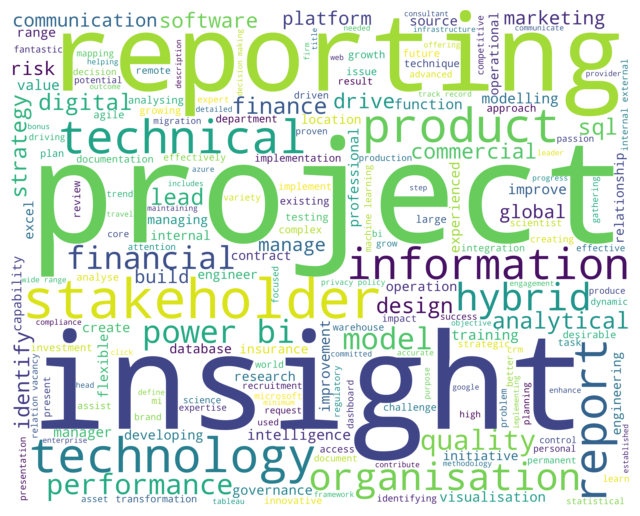

In [380]:
# Add words that frequently appear in the descriptions but carry no value
from sklearn.feature_extraction import text
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

extra_stopword = ['data','business','experience','team','role','job','contact','note',
                  'require','current','activity','working','work','analyst','skill','skills',
                  'uk','london','apply','employment','agency','opportunity','support',
                  'supporting','management','process','deliver','delivery','delivering',
                  'client','company','within','customer','requirement','required','including',
                  'successful','candidate','looking','analysis','analytics','solution',
                  'knowledge','need','ensure','key','new','using','application','graduate',
                  'qualification','junior','senior','banking','group','level','day','join',
                  'based','time','use','understand','understanding','benefit','year','market',
                  'excellent','develop','development','responsibility','service','will',
                  'provide','providing','help','change','relevant','include','set','able',
                  'wider','youll','whilst','colleague','environment','like','end','leading',
                  'ideally','ideal','bring','responsible','offer','people','various','duty',
                  'right','exciting','ha','building','life','career','great','focus','home',
                  'meet','user','multiple','employee','area','good','make','ensuring','salary',
                  'pricing','essential','industry','following','case','office','clear','package',
                  'background','tool','equal','finding','act','want','week','closely','similar',
                  'different','related','site','order','hr','interested','member','hour','maintain',
                  'u','line','andor','seeking','month','culture','standard','programme','sector','enable',
                  'appropriate','community','best','sale','previous','partner','way','ability','interview',
                  'position','individual','staff','highly','prsent','journey','know','come','exisiting',
                  'place','look','strong','practice','alongside','recommendation','currently','available']
exstopwords = text.ENGLISH_STOP_WORDS.union(extra_stopword)
text = " ".join(datajobs['descriptionclean'])
wc = WordCloud(width = 5000, height = 4000, 
                    background_color ='white', 
                    stopwords = exstopwords, 
                    min_font_size = 12).generate(text)


plt.figure(figsize = (8, 8)) 
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()

### Visualizing data skills

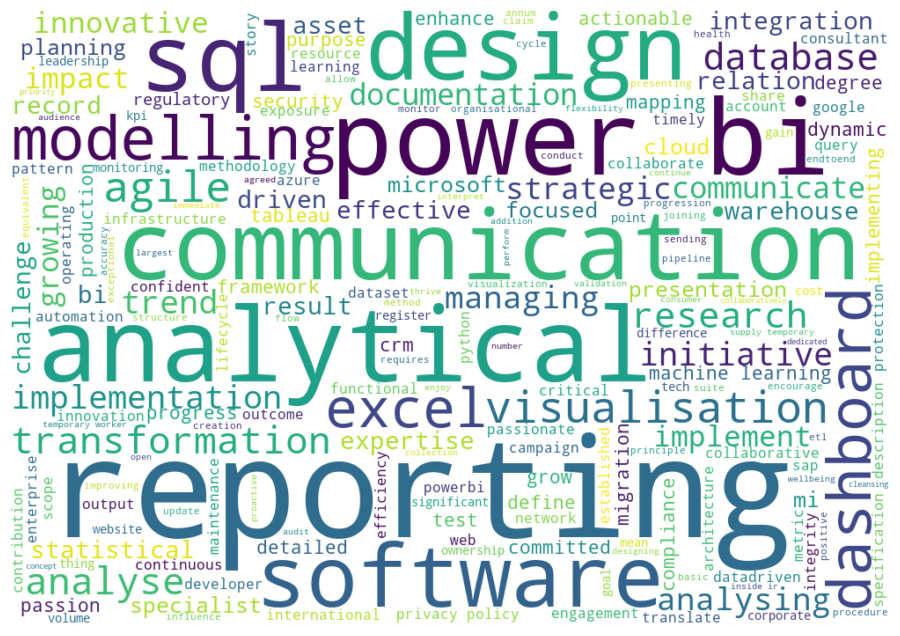

In [57]:
# Remove words that aren't skills
from sklearn.feature_extraction import text

extra_stopword = ['data','business','experience','team','role','job','contact','note','require','current','activity','working','work','analyst','skill','skills','uk','london','apply','employment',
                  'agency','opportunity','support','supporting','management','process','deliver','delivery','delivering','client','company','within','customer','requirement','required','requirements',
                  'including','successful','candidate','looking','analysis','analytics','solution','knowledge','need','needs','years','ensure','key','new','using','application','graduate','qualification','junior',
                  'senior','banking','group','level','day','join','based','time','use','understand','understanding','benefit','year','market','excellent','develop','development','responsibility','service',
                  'will','provide','providing','help','change','relevant','include','set','able','wider','youll','whilst','colleague','environment','like','end','leading','ideally','ideal','bring','responsible',
                  'offer','people','various','duty','right','exciting','ha','building','life','career','great','focus','home','meet','user','multiple','employee','area','good','make','ensuring','salary','pricing',
                  'essential','industry','following','case','office','clear','package','background','tool','equal','finding','act','want','week','closely','similar','different','related','site','order','hr',
                  'interested','member','hour','maintain','u','line','andor','seeking','month','culture','standard','programme','sector','enable','appropriate','community','best','sale','previous','partner',
                  'way','ability','interview','position','individual','staff','highly','prsent','journey','know','come','exisiting','place','look','strong','experience', 'following', 'candidates', 'big', 'background',
                  'developing', 'characteristics', 'data', 'team', 'data', 'scientist', 'strong', 'project','benefits','services', 
                  'solution', 'technology', 'science', 'model', 'knowledge','skill', 'work', 'build', 'will', 'knowledge', 'application','gender', 'identity', 'equal',
                  'opportunity','related','field', 'without', 'regard', 'national', 'origin', 'religion', 'sex', 'race', 'color', 'veteran', 'status','sexual',
                  'orientation','opportunity', 'employer', 'qualified','applicant','skills', 'job', 'summary', 'advanced', 'system', 'applicants', 'receive', 'large', 'best', 'practice', 'problem'
                 , 'processing', 'affirmative', 'action', 'employment', 'consideration', 'receive', 'united', 'state', 'computer', 'working', 'saying', 
                  'preferred', 'qualification', 'disability', 'protected', 'structured', 'unstructured', 'problems', 'technical', 'internal', 'external', 'non',
                 'subject', 'matter', 'please', 'apply', 'using', 'dental', 'reasonable', 'accomodation', 'join', 'us', 'tools', 'individuals', 'disabilities'
                 , 'type', 'full', 'wide', 'range', 'duties', 'responsibilities', 'stakeholder', 'oral', 'written', 'ideal', 'candidate', 'ability', 'qualifications', 'well',
                  'must', 'able', 'unit', 'member', 'posted', 'today', 'service', 'clearance', 'days', 'ago', 'high', 'quality', 'level', 'every', 'use', 'case', 'additional','report','hybrid','performance','product','financial','information',
                 'professional', 'source','core','future','fantastic','permanent','driving','commercial','approach','manager','improve','organisation','manage','insight','digital',
                 'relationship','platform','global','create','success','growth','lead','recommendation','finance','department','desirable','attention','insurance',
                 'experienced','engineer','engineering','title','available','recruitment','issue','capability','location','value','needed','training','review','complex','contract',
                 'identify','marketing','investment','currently','maintaining','acting','access','existing','used','head','annual leave','risk','bonus','regular','k','option','vacancy',
                 'provider','technique','helping','alongside','solving','limited','strategy','main','remote','plus','basis','variety','discount','fully','leader','effectively','produce','expert',
                 'retail','holiday','offering','bank','task','minimum','annual','request','firm','considered','contribute','welcome','better','personal','intelligence','specific','control',
                 'present','track record','potential','document','travel','assist','proven','directly','energy','governance','identifying','involve','ongoing','person','necessary','improvement','track',
                 'applying','includes','drive','recruiting','objective','leave','diverse','scheme','inclusive','step','brand','pension','central','creating','click','operate','send cv','accurate',
                 'operation','portfolio','online','overallthing','function','decision','really','operational','possible','competitive','making','world','send','cv','demonstrate','sound','achieve','learn',
                 'provided','assurance','verbal','credit','meeting','comfortable','consultancy','trading','forward','touch','public','owner','plan','supplier','establish','suitable','testing',
                 'inform','initial','preferably','involved','chance','expected','ba','writing','overall','form','follow','real','talented','suit','important','extensive','play','base','monthly','return',
                 'date','apprenticeship','complete','gather','independently','gathering','start','apprentice','dedicated start','flexible']
exstopwords = text.ENGLISH_STOP_WORDS.union(extra_stopword)
text = " ".join(datajobs['descriptionclean'])
wc = WordCloud(width=1000, height=700,background_color ='white', stopwords = exstopwords).generate(text)


plt.figure(figsize = (12, 8)) 
plt.imshow(wc,interpolation="bilinear")
plt.axis('off')
plt.show()



#### Technical skills analysis

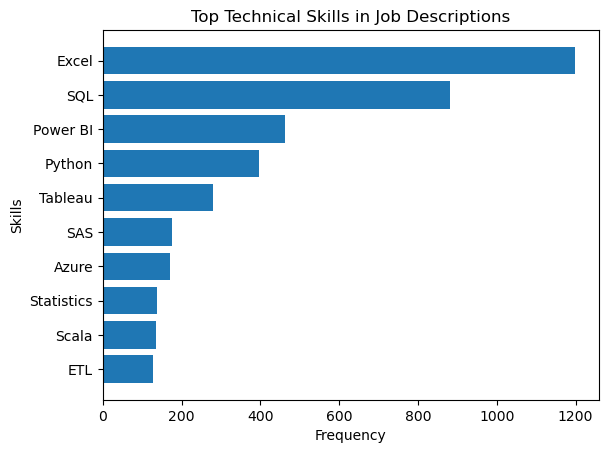

In [58]:
# List of technical skills to search for
skills = ["Python","Tableau","Power BI","c++","java","matlab",".net","c#","javascript",
          "html","bash", "big data", "Sybase","Google Analytics","NoSQL"
          ,"hadoop","spark","impala","cassandra","kafka","hdfs","hbase","hive",
          "AWS","gcp","Azure","s3","redshift","ec2","lambda","route s3","dynamo db",
          "time series","regression","numpy","pandas",
          "time series","data cleaning","deep learning","SQL","mongo db","Excel", 
          "SAS","nosql","Java","Scala", "Machine Learning","matlab", "Data warehousing",
          "ETL", "oracle", "Data mining","Data modeling","C++","Statistics"]

# Initialize a dictionary to store skill frequencies
skill_freq = {}

# Iterate over each job description
for desc in datajobs['description']:
    for skill in skills:
        if skill.lower() in desc.lower():
            skill_freq[skill] = skill_freq.get(skill, 0) + 1

# Sort the dictionary by frequency counts in descending order
sorted_skills = sorted(skill_freq.items(), key=lambda x: x[1], reverse=True)

# Extract the top skills and their frequencies
top_skills = [skill[0] for skill in sorted_skills[:10]][::-1]  # Reverse order
skill_counts = [skill[1] for skill in sorted_skills[:10]][::-1] 

# Create a bar chart to visualize the top skills
plt.barh(top_skills, skill_counts)
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Top Technical Skills in Job Descriptions')
plt.show()


#### Soft skills analysis

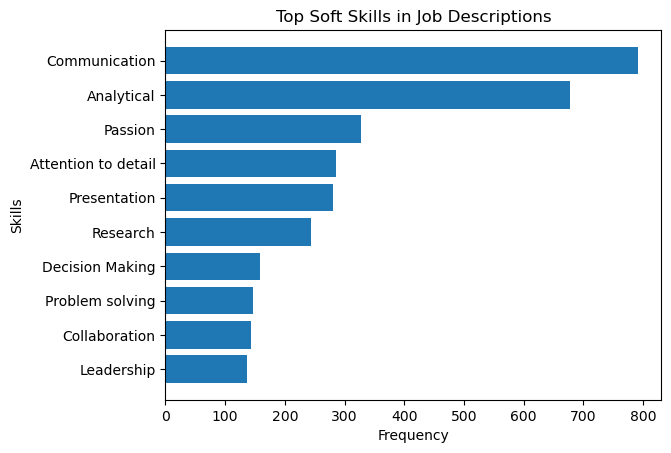

In [59]:
# List of soft skills to search for
skills = ['Communication', 'Problem solving','Creativity','Leadership','Collaboration','Adaptability',
         'Time management', 'Storytelling', 'Critical thinking','Teamwork','Curiosity','Business acumen',
          'Analytical','Attention to detail', 'Presentation', 'Project Management','Research', 'Decision Making',
         'Inquisitiveness','Passion','Logical thinking','Organization','Risk assessment','Risk Management']

# Initialize a dictionary to store skill frequencies
skill_freq = {}

# Iterate over each job description
for desc in datajobs['description']:
    for skill in skills:
        if skill.lower() in desc.lower():
            skill_freq[skill] = skill_freq.get(skill, 0) + 1

# Sort the dictionary by frequency counts in descending order
sorted_skills = sorted(skill_freq.items(), key=lambda x: x[1], reverse=True)

# Extract the top skills and their frequencies
top_skills = [skill[0] for skill in sorted_skills[:10]][::-1]  # Reverse order
skill_counts = [skill[1] for skill in sorted_skills[:10]][::-1] 

# Create a horizontal bar chart to visualize the top skills
plt.barh(top_skills, skill_counts)
plt.xlabel('Frequency')
plt.ylabel('Skills')
plt.title('Top Soft Skills in Job Descriptions')
plt.show()


### Visualizing Data Analyst Salaries

In [69]:
datajobs.isna().sum()

title                 0
company               0
salary_type           0
salary_min          439
salary_max          439
annual_salary       439
city                  0
region                0
country               0
remote                0
status1               0
status2               0
description           0
descriptionclean      0
link                  0
dtype: int64

In [61]:
# drop columns with no salary for salary analysis
datajobs_ws = datajobs.dropna().reset_index(drop=True)

In [77]:
# make a dataframe for rows with no salary for model

# create a boolean mask for rows with NaN values in specific columns
nan_rows_mask = datajobs[['salary_min', 'salary_max', 'annual_salary']].isnull().any(axis=1)

# filter the DataFrame to keep only the rows with NaN values
datajobs_ns = datajobs[nan_rows_mask].reset_index(drop=True)

print(datajobs_ns.shape)

(439, 15)


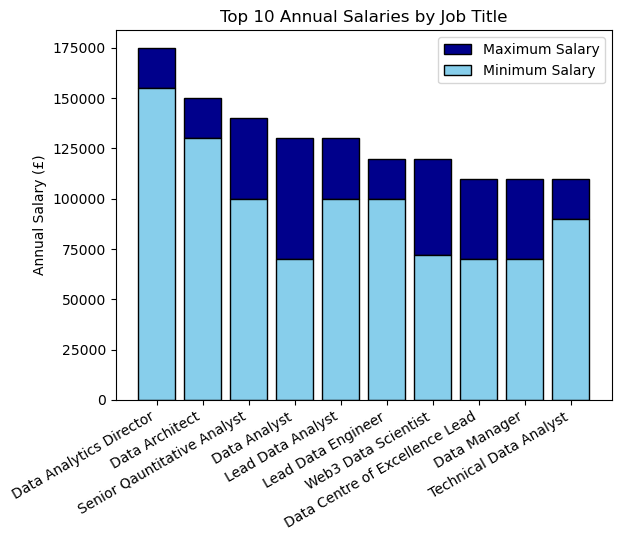

In [79]:
# Sort the dataframe by annual salary in descending order and select top
annual_salaries = datajobs_ws[datajobs_ws['salary_type'] == 'annual']
annual_salaries = annual_salaries.sort_values(by='salary_max', ascending=False)
topjobs = annual_salaries.iloc[:10]


# Create a bar plot for the top 10 job titles by annual salary
plt.bar(topjobs['title'], topjobs['salary_max'] - topjobs['salary_min'], bottom=topjobs['salary_min'], color='darkblue', edgecolor='black', label='Maximum Salary')
plt.bar(topjobs['title'], topjobs['salary_min'], color='skyblue', edgecolor='black', label='Minimum Salary')

# Set the title and axis labels for the plot
plt.title('Top 10 Annual Salaries by Job Title')
plt.ylabel('Annual Salary (£)')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=30, ha='right')

# Remove grid lines
plt.grid(False)

# Add a legend
plt.legend()

#set new tick labels for the x-axis
new_xtick_labels = ['Data Analytics Director','Data Architect','Senior Qauntitative Analyst','Data Analyst','Lead Data Analyst','Lead Data Engineer','Web3 Data Scientist', 'Data Centre of Excellence Lead', 'Data Manager', 'Technical Data Analyst']
plt.xticks(range(len(topjobs)), new_xtick_labels)

# Display the plot
plt.show()


### Location analysis

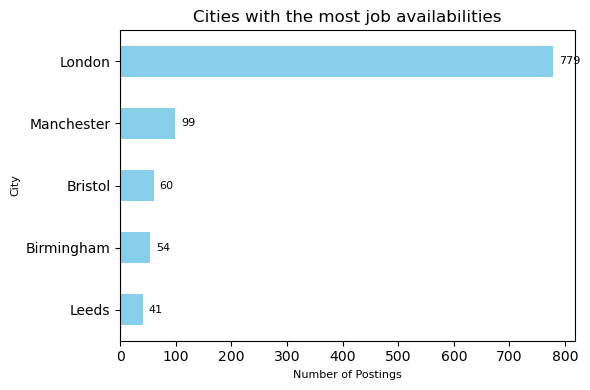

In [394]:
# Group by 'city' column and count the number of job postings
city_counts = datajobs.groupby('city')['title'].count().sort_values(ascending=False).head(5)

# Plotting the horizontal bar graph
plt.figure(figsize=(6, 4))
city_counts.plot(kind='barh', color='skyblue')

# Customizing the plot
plt.title('Cities with the most job availabilities', fontsize=12)
plt.xlabel('Number of Postings', fontsize=8)
plt.ylabel('City', fontsize=8)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()

# Adding data labels
for i, v in enumerate(city_counts):
    plt.text(v + 10, i, str(v), color='black', va='center', fontsize=8)

# Display the plot
plt.tight_layout()
plt.show()


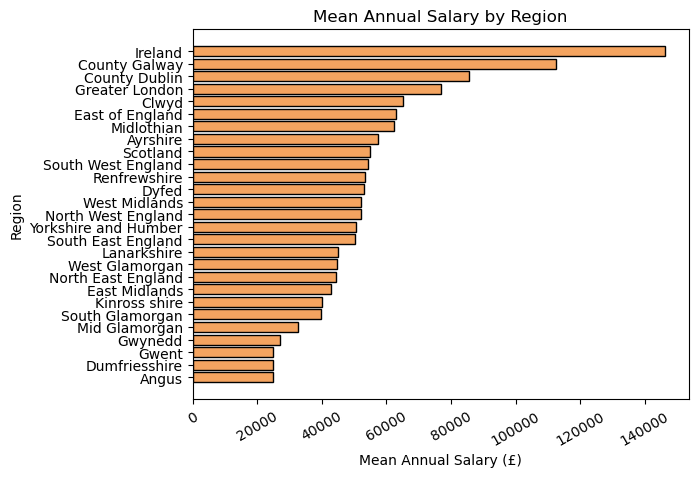

In [82]:
# group the data by region and calculate the mean annual salary
d1 = datajobs_ws.groupby(['region']).agg({'annual_salary': np.mean})
d1 = d1.sort_values(by='annual_salary', ascending=False)

# bar plot of the mean annual salary by region
plt.barh(d1.index, d1['annual_salary'], color='sandybrown', edgecolor='black')

# set the title and labels for the plot
plt.gca().invert_yaxis()
plt.title('Mean Annual Salary by Region')
plt.xlabel('Mean Annual Salary (£)')
plt.ylabel('Region')

# rotate the x-axis labels for better visibility
plt.xticks(rotation=30)

# show the plot
plt.show()

In [83]:
datajobs_ws[datajobs_ws['country'] == 'England'].groupby('region')['annual_salary'].mean()

region
East Midlands           42891.323077
East of England         62924.604651
Greater London          76747.816225
North East England      44250.617647
North West England      52111.380435
South East England      50256.095420
South West England      54134.555556
West Midlands           52218.272358
Yorkshire and Humber    50710.861111
Name: annual_salary, dtype: float64

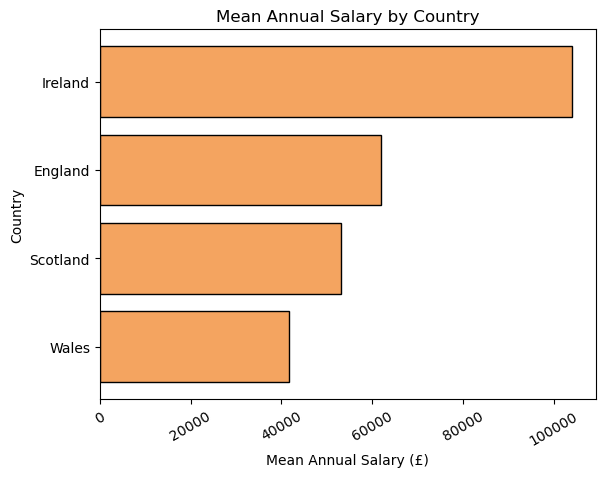

In [84]:
# group the data by country and calculate the mean annual salary
d2 = datajobs_ws.groupby(['country']).agg({'annual_salary': np.mean})
d2 = d2.sort_values(by='annual_salary', ascending=False)

# bar plot of the mean annual salary by region
plt.barh(d2.index, d2['annual_salary'], color='sandybrown', edgecolor='black')

# set the title and labels for the plot
plt.gca().invert_yaxis()
plt.title('Mean Annual Salary by Country')
plt.xlabel('Mean Annual Salary (£)')
plt.ylabel('Country')

# rotate the x-axis labels for better visibility
plt.xticks(rotation=30)

# show the plot
plt.show()

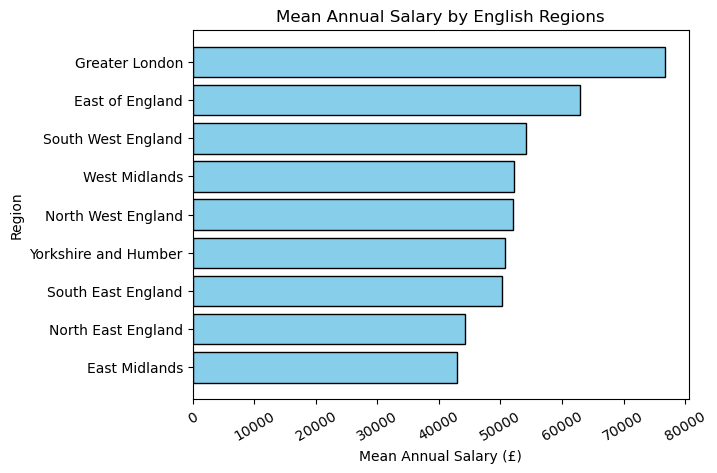

In [85]:
# group the data by country and calculate the mean annual salary
d3 = datajobs_ws[datajobs_ws['country'] == 'England'].groupby('region').agg({'annual_salary': np.mean})
d3 = d3.sort_values(by='annual_salary', ascending=False)

# bar plot of the mean annual salary by region
plt.barh(d3.index, d3['annual_salary'], color='skyblue', edgecolor='black')

# set the title and labels for the plot
plt.gca().invert_yaxis()
plt.title('Mean Annual Salary by English Regions')
plt.xlabel('Mean Annual Salary (£)')
plt.ylabel('Region')

# rotate the x-axis labels for better visibility
plt.xticks(rotation=30)

# show the plot
plt.show()

### Visualizing Junior and Senior roles

In [415]:
#Select Data Analyst postings from the listings
juniorroles = datajobs[datajobs['title'].str.lower().str.contains("junior|graduate|apprentice|entry level|entry-level|entrylevel|trainee|intern|internship|grad|jr|jr.|entry")]
seniorroles = datajobs[datajobs['title'].str.lower().str.contains("senior|lead|head|vp|director|manager|principal|partner|chief")]

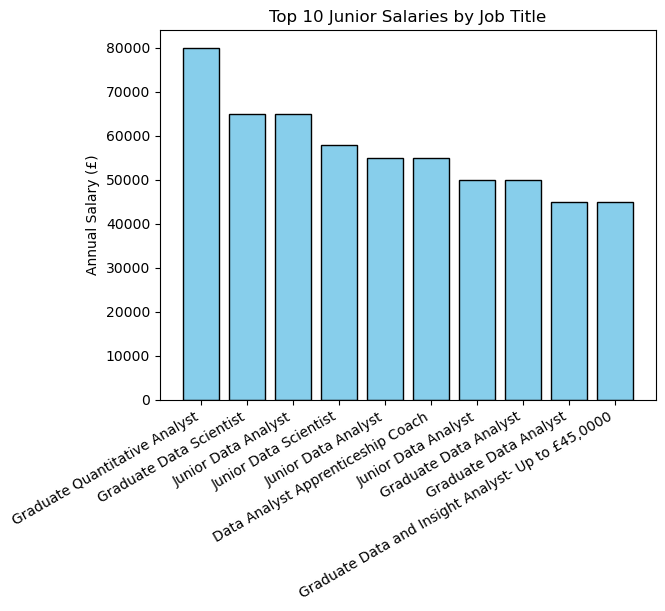

In [416]:
# sort the dataframe by annual salary in descending order and select top
juniorroles_salaries = juniorroles[juniorroles['salary_type'] == 'annual']
topjuniorjobs = juniorroles_salaries.sort_values(by='salary_max', ascending=False)
topjuniorjobs = topjuniorjobs.iloc[:10]

# add random jitter to x-axis positions
jitter = np.random.normal(scale=0, size=len(topjuniorjobs))
x = np.arange(len(topjuniorjobs)) + jitter

# create a bar plot for the top 10 job titles by annual salary
plt.bar(x, topjuniorjobs['salary_max'], color='skyblue', edgecolor='black')

# set the x-axis tick labels to the job titles
plt.xticks(x, topjuniorjobs['title'], rotation=30, ha='right')

# set the title and axis labels for the plot
plt.title('Top 10 Junior Salaries by Job Title')
plt.ylabel('Annual Salary (£)')

#set new tick labels for the x-axis
# new_xtick_labels = ['Junior Quantitative Analyst', 'Junior Data Scientist','Junior Data Analyst', 'Graduate Data Scientist', 'Junior Data Analyst', 'Graduate Data Analyst', 'Junior Data Insight Analyst', 'Junior IT Data Consultant', 'Graduate ML Engineer','Graduate Data Analyst']
# plt.xticks(range(len(topjobs)), new_xtick_labels)

plt.show()


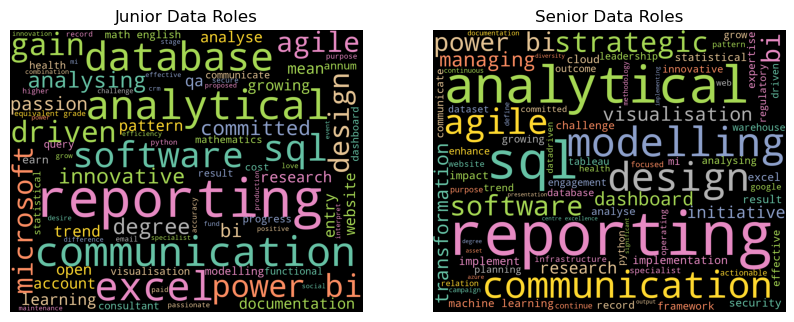

In [88]:
# generate word clouds for junior and senior roles
junior_wc = WordCloud(background_color='black', colormap='Set2', random_state=1, stopwords=exstopwords, max_words=80, width=1500, height=1200).generate(' '.join(juniorroles['descriptionclean']))
senior_wc = WordCloud(background_color='black', colormap='Set2', random_state=1, stopwords=exstopwords, max_words=80, width=1500, height=1200).generate(' '.join(seniorroles['descriptionclean']))

# create a figure with two subplots for the word clouds
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# set the title for the subplots
axs[0].set_title('Junior Data Roles')
axs[1].set_title('Senior Data Roles')

# display the word clouds in the subplots
axs[0].imshow(junior_wc)
axs[1].imshow(senior_wc)

# remove the axis labels from the subplots
axs[0].axis('off')
axs[1].axis('off')

# display the figure
plt.show()


In [417]:
# Check the mean salary for junior and senior roles
junior_mean_salary = juniorroles['annual_salary'].mean()
senior_mean_salary = seniorroles['annual_salary'].mean()

print("Mean annual salary for junior roles:", junior_mean_salary)
print("Mean annual salary for senior roles:", senior_mean_salary)

Mean annual salary for junior roles: 29955.641025641027
Mean annual salary for senior roles: 71363.66966966967


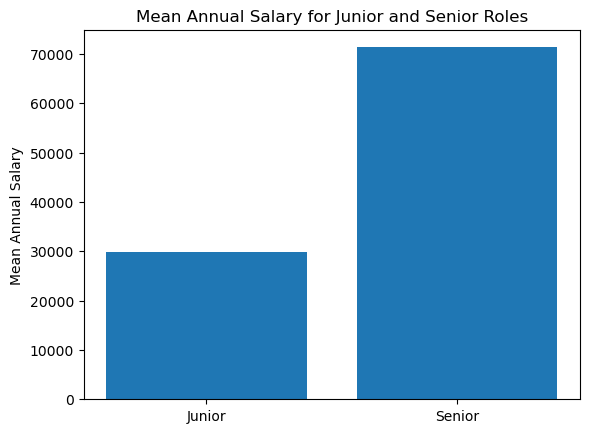

In [418]:
# Plotting the mean salaries
fig, ax = plt.subplots()
ax.bar(['Junior', 'Senior'], [junior_mean_salary, senior_mean_salary])
ax.set_ylabel('Mean Annual Salary')
ax.set_title('Mean Annual Salary for Junior and Senior Roles')
plt.show()

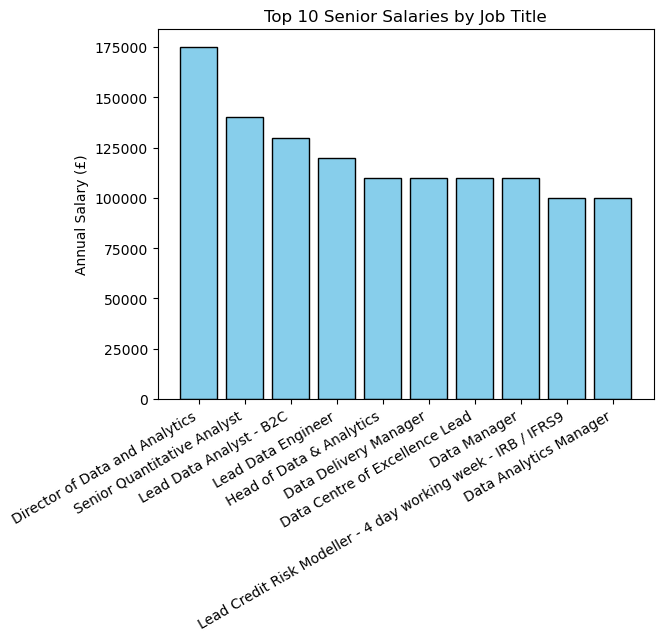

In [92]:
# sort the dataframe by annual salary in descending order and select top
seniorroles_salaries = seniorroles[seniorroles['salary_type'] == 'annual']
topseniorjobs = seniorroles_salaries.sort_values(by='salary_max', ascending=False)
topseniorjobs = topseniorjobs.iloc[:10]

# add random jitter to x-axis positions
jitter = np.random.normal(scale=0, size=len(topseniorjobs))
x = np.arange(len(topseniorjobs)) + jitter

# create a bar plot for the top 10 job titles by annual salary
plt.bar(x, topseniorjobs['salary_max'], color='skyblue', edgecolor='black')

# set the x-axis tick labels to the job titles
plt.xticks(x, topseniorjobs['title'], rotation=30, ha='right')

# set the title and axis labels for the plot
plt.title('Top 10 Senior Salaries by Job Title')
plt.ylabel('Annual Salary (£)')

#set new tick labels for the x-axis
#new_xtick_labels = ['Junior Data Analyst', 'Graduate Data Scientist','Junior Data Scientist', 'Graduate Data Analyst', 'Junior Data Analyst', 'Graduate Data Analyst', 'Graduate Data Insight Analyst', 'Graduate IT Data Consultant', 'Graduate Data Analyst', 'Graduate ML Engineer']
#plt.xticks(range(len(topjobs)), new_xtick_labels)

plt.show()

### Visualizing remote roles

In [93]:
remoteroles_ns = datajobs[datajobs['remote']=='yes']
remoteroles_ws = datajobs_ws[datajobs_ws['remote']=='yes']

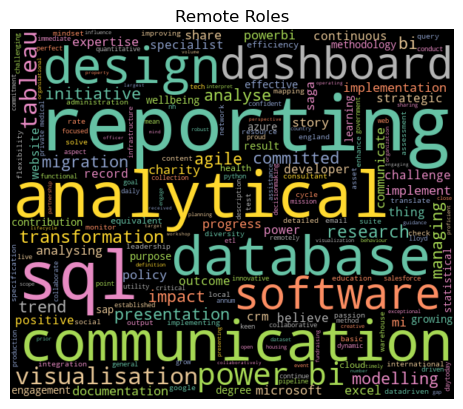

In [94]:
#word cloud
text = " ".join(remoteroles_ns['descriptionclean'])

wc= WordCloud(random_state=1,background_color='black', colormap='Set2', stopwords=exstopwords, width =600, height = 500)
wc.generate(text)

fig, axs = plt.subplots()
axs.imshow(wc, interpolation="bilinear")
axs.axis('off')

# set the title of the axes
axs.set_title("Remote Roles")
plt.show()

In [95]:
# Check the mean salary for remote roles
remote_mean_salary = remoteroles_ns['annual_salary'].mean()
print("Mean annual salary for remote roles:", remote_mean_salary)

Mean annual salary for remote roles: 60383.816


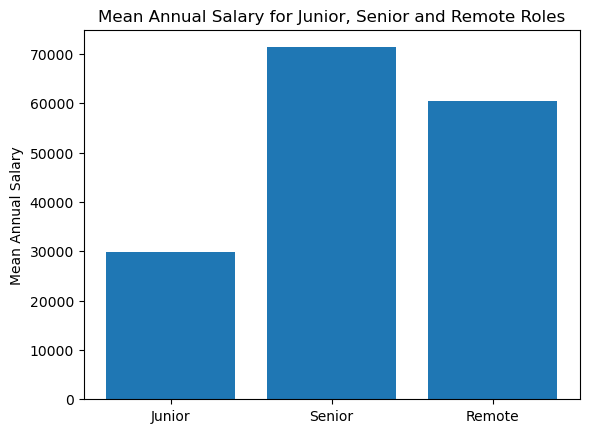

In [96]:
# Compare with junior and senior roles and plot the mean salaries
fig, ax = plt.subplots()
ax.bar(['Junior', 'Senior', 'Remote'], [junior_mean_salary,senior_mean_salary,remote_mean_salary])
ax.set_ylabel('Mean Annual Salary')
ax.set_title('Mean Annual Salary for Junior, Senior and Remote Roles')
plt.show()

What can this tell us about remote roles? Could this mean that they are mostly for senior analysts?

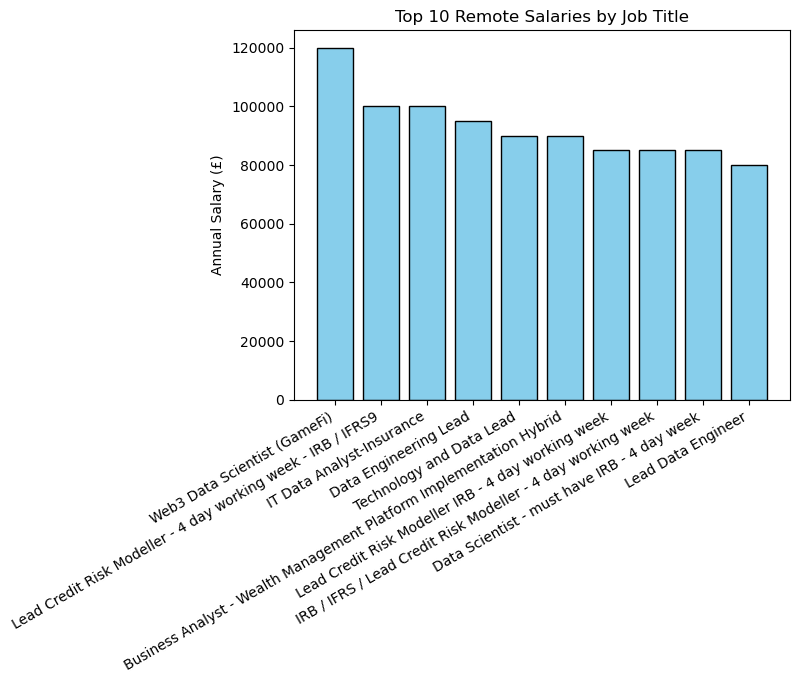

In [97]:
# sort the dataframe by annual salary in descending order and select top remote salaries
remote_salaries = remoteroles_ws[remoteroles_ws['salary_type'] == 'annual']
topremotejobs = remote_salaries.sort_values(by='salary_max', ascending=False)
topremotejobs = topremotejobs[:10]

# create a bar plot for the top 10 job titles by annual salary
plt.bar(topremotejobs['title'], topremotejobs['annual_salary'], color='skyblue', edgecolor='black')

# set the title and axis labels for the plot
plt.title('Top 10 Remote Salaries by Job Title')
plt.ylabel('Annual Salary (£)')

# rotate the x-axis labels for better readability
plt.xticks(rotation=30, ha='right')

#set new tick labels for the x-axis
# new_xtick_labels = ['Web3 Data Scientist','IT Data Analyst','Technology & Data Lead','Business Analyst','Data Scientist', 'Data Engineer', 'Data Migrations Analyst', 'Lead Data Engineer', 'Tech Lead Data Engineer','Business Consultant']
# plt.xticks(range(len(topjobs)), new_xtick_labels)

# display the plot
plt.show()


# Modeling

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
import seaborn as sns

In [99]:
display(datajobs_ws.shape)
display(datajobs_ns.shape)

(1537, 15)

(439, 15)

#### Lets create a new target where annual salary is either high or low

In [100]:
np.percentile(datajobs_ws['annual_salary'], 65)

60000.0

In [101]:
# get the 65th percentile value of salary
sal65 = np.percentile(datajobs_ws['annual_salary'], 65)

In [102]:
# make a new target variable that captures whether salary is high (1) or low (0)
datajobs_ws['salary_target'] = np.where(datajobs_ws['annual_salary'] >= sal65, 1, 0)

In [103]:
datajobs_ws.salary_target.value_counts()

0    926
1    611
Name: salary_target, dtype: int64

In [104]:
datajobs_ws.salary_target.value_counts()/len(datajobs_ws)

0    0.602472
1    0.397528
Name: salary_target, dtype: float64

In [360]:
#get X and Y
X = datajobs_ws['description']
y = datajobs_ws['salary_target']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [361]:
# transform X_train and X_test variables into numerical feature vectors of token counts
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

#### Logistic Regression Model

In [362]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_counts, y_train)

# Evaluate the model
y_pred2 = logreg.predict(X_test_counts)
accuracy = logreg.score(X_test_counts, y_test)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)

print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy, precision, recall, f1))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, y_pred2))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred2))

Accuracy: 0.83, Precision: 0.81, Recall: 0.78, F1 Score: 0.79
Area under the ROC curve: 0.8207070707070706
Model Confusion Matrix:
 [[228  36]
 [ 44 154]]


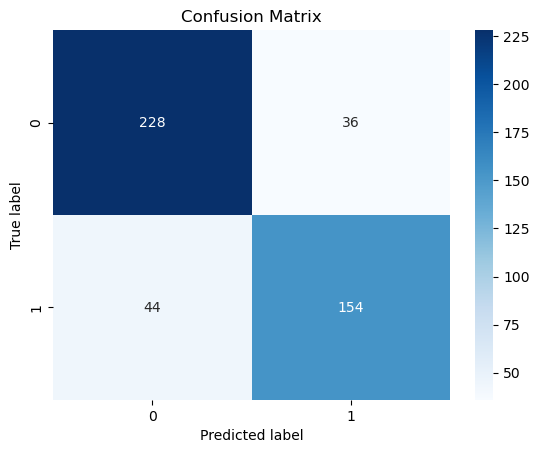

In [363]:
# create confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred2)

# create heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# set labels for the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# display the plot
plt.show()

#### MultinomialNB Model

In [369]:
mnb_model = MultinomialNB(alpha=0.4, fit_prior=True)
mnb_model.fit(X_train_counts, y_train)

# Evaluate the model
y_pred1 = mnb_model.predict(X_test_counts)
accuracy = mnb_model.score(X_test_counts, y_test)
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)

print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy, precision, recall, f1))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, y_pred1))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred1))

Accuracy: 0.83, Precision: 0.83, Recall: 0.76, F1 Score: 0.79
Area under the ROC curve: 0.821969696969697
Model Confusion Matrix:
 [[234  30]
 [ 48 150]]


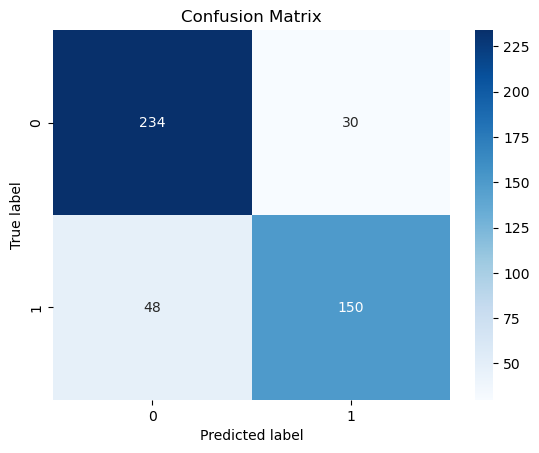

In [370]:
# create confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred1)

# create heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# set labels for the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# display the plot
plt.show()

#### Support Vector Machines

In [372]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_model = SVC(C=1.0, kernel='linear')

# Train the SVM model
svm_model.fit(X_train_counts, y_train)

# Evaluate the model
y_pred3 = svm_model.predict(X_test_counts)
accuracy = svm_model.score(X_test_counts, y_test)
precision = precision_score(y_test, y_pred3)
recall = recall_score(y_test, y_pred3)
f1 = f1_score(y_test, y_pred3)

print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(accuracy, precision, recall, f1))
print("Area under the ROC curve:", metrics.roc_auc_score(y_test, y_pred3))
print("Model Confusion Matrix:\n", metrics.confusion_matrix(y_test, y_pred3))

Accuracy: 0.83, Precision: 0.81, Recall: 0.80, F1 Score: 0.81
Area under the ROC curve: 0.8295454545454545
Model Confusion Matrix:
 [[226  38]
 [ 39 159]]


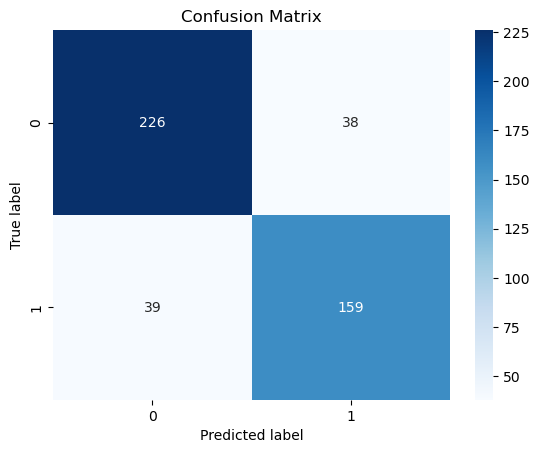

In [373]:
# create confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred3)

# create heatmap
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# set labels for the plot
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# display the plot
plt.show()

### Use on whole dataframe

In [375]:
# jobs with salaries
X_data_counts = count_vectorizer.transform(datajobs_ws['description'])
predictions = svm_model.predict(X_data_counts)
datajobs_ws['predictions'] = predictions

In [378]:
# jobs without salaries
X_data_counts2 = count_vectorizer.transform(datajobs_ns['description'])
predictions2 = svm_model.predict(X_data_counts2)
datajobs_ns['sal_predictions'] = predictions2

In [414]:
reshuffled_df = datajobs_ns.sample(frac=1).reset_index(drop=True)
reshuffled_df[['title', 'company', 'city', 'description', 'salary_type', 'sal_predictions']].head(10)

title                 company  \
0  Data Analyst Must have Tableau experience  Page Personnel Finance   
1                 Technical Business Analyst       eFinancialCareers   
2                       Pricing Data Analyst       eFinancialCareers   
3                    Senior Business Analyst         Erin Associates   
4                Data Modeler - Company Data       eFinancialCareers   
5                          Risk Data Analyst        The Access Group   
6                           Graduate Analyst         VRS Recruitment   
7   Business Analyst - Life Science/R&D/Data                  Lorien   
8      Business Analyst Apprentice - Bristol        Careers In Group   
9                          Reporting Analyst            Kennedys Law   

            city                                        description  \
0        Kinross  Our client is looking for a Data Analyst  Clie...   
1     Manchester  Within the Software Solutions division, the Bu...   
2         London  Transfer existing pricing models from both Exc...   
3       Spalding  Business Analyst - Lincolnshire, Spalding, Mid...   
4         London  Bloomberg runs on data, and the Bloomberg Data...   
5   Loughborough  Risk data analystHybrid working - 2 days will ...   
6  Middlesbrough  Fantastic opportunity for an enthusiastic Scie...   
7      Bracknell  Business Analyst - Life Sciences/R&D/Data 9 Mo...   
8        Bristol  End dateTuesday 09 May 2023 Salary rangeWe sup...   
9     Chelmsford  Kennedys is looking for a Reporting Analyst to...   

  salary_type  sal_predictions  
0     unknown                0  
1     unknown                1  
2     unknown                0  
3     unknown                1  
4     unknown                1  
5     unknown                0  
6     unknown                0  
7     unknown                1  
8     unknown                1  
9     unknown                1

### Job Search Filter

In [237]:
datajobs.head()

title                                 company salary_type  \
0  Data Analyst              e.surv Chartered Surveyors     unknown   
1  Data Analyst      University of the West of Scotland      annual   
2  Data Analyst                       Brandon James Ltd      annual   
3  Data Analyst                   The Consultancy Group      annual   
4  Data Analyst  Harnham - Data & Analytics Recruitment      annual   

   salary_min  salary_max  annual_salary        city              region  \
0         NaN         NaN            NaN   Kettering       East Midlands   
1     32000.0     39000.0        39000.0     Paisley        Renfrewshire   
2     40000.0     45000.0        45000.0     Bristol  South East England   
3     35000.0     50000.0        50000.0      London      Greater London   
4     40000.0     60000.0        60000.0  Kilmarnock            Ayrshire   

    country remote    status1     status2  \
0   England    yes  Permanent   full-time   
1  Scotland     no   Contract   full-time   
2   England     no   Contract   full-time   
3   England     no  Permanent   full-time   
4  Scotland     no  Permanent   full-time   

                                    descriptionclean  \
0  trading since esurv chartered surveyor uk numb...   
1  registry full time fixedterm month post data a...   
2  strategic medium sized consultancy seeking pro...   
3  partnered renowned retail business looking dat...   
4  data analyst kilmarnockup currently working le...   

                                                link  
0  https://www.reed.co.uk/jobs/data-analyst/49988...  
1  https://www.reed.co.uk/jobs/data-analyst/50197...  
2  https://www.reed.co.uk/jobs/data-analyst/50020...  
3  https://www.reed.co.uk/jobs/data-analyst/50188...  
4  https://www.reed.co.uk/jobs/data-analyst/50184...

In [419]:
datajobs.to_csv('streamlit.csv', index=False)

In [ ]:
#Filter 1 = Junior jobs
#Filter 2 = Senior roles
#Filter 3 = Remote roles
#Filter 4 = Contract Jobs

In [420]:
def search_jobs():
    # Load the job DataFrame
    df_jobs = datajobs
    
    # Get user input for keywords
    junior = input("Filter by junior jobs? (y/n) ").lower() == 'y'
    senior = input("Filter by senior jobs? (y/n) ").lower() == 'y'
    remote = input("Filter by remote jobs? (y/n) ").lower() == 'y'
    contract = input("Filter by contract jobs? (y/n) ").lower() == 'y'

    
    # Filter the DataFrame based on the input keywords
    if contract:
        df_jobs = df_jobs[df_jobs['status1'] == 'Contract']
    if remote:
        df_jobs = df_jobs[df_jobs['remote'] == 'yes']
    if junior:
        df_jobs = df_jobs[df_jobs['title'].str.lower().str.contains("junior|graduate|apprentice|entry level|entry-level|entrylevel|trainee|intern|internship|grad")]
    if senior:
        df_jobs = df_jobs[df_jobs['title'].str.lower().str.contains("senior|lead|head|vp|director|manager|principal|partner|chief")]
        
            
    # format salary and link
    df_jobs['annual_salary £'] = df_jobs['annual_salary'].fillna('negotiable').apply(lambda x: '{:.0f}'.format(x) if isinstance(x, float) else x)
    df_jobs['joblink'] = df_jobs['link'].apply(lambda x:'<a href="{0}" target="_blank">link</a>'.format(x))
    df_jobs = df_jobs.reset_index(drop=True)    
    
    # Return the filtered jobs
    print(f"{len(df_jobs)} job(s) found.")
    return df_jobs[['title','city','country','status1','status2','annual_salary £','joblink']].style.format({'link': lambda x: x if x.startswith('<a') else '<a>{}</a>'.format(x)})


In [421]:
#pd.reset_option('display.max_colwidth')
search_jobs()

Filter by junior jobs? (y/n) y
Filter by senior jobs? (y/n) n
Filter by remote jobs? (y/n) n
Filter by contract jobs? (y/n) y
9 job(s) found.
